# **Downloading the data**

In [ ]:
!git clone "https://github.com/Ayma-n/dl-fp"

Cloning into 'dl-fp'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 294 (delta 88), reused 95 (delta 41), pack-reused 147
Receiving objects: 100% (294/294), 3.54 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [ ]:
!cd /content/dl-fp/ && git pull && cd ..

Already up to date.


# Dependencies

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9xgk5hr3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9xgk5hr3
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

# Preprocessing Dependencies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Deep Learning FP/Final Datasets/annotations_trainval2017.zip" -d "/content/Unzipped/"

In [ ]:
!unzip -q "/content/drive/MyDrive/Deep Learning FP/Final Datasets/LARGE_train_offline_preprocess.zip" -d "/content/Unzipped/"

replace /content/Unzipped/train_offline_preprocess/000000148118.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Constant for batch size
BATCH_SIZE = 32

In [ ]:
#UP TO DATE PRE-PROCESSING
import os
import tensorflow as tf
os.chdir("/content/dl-fp/")
import preprocess as pp

images_path = "/content/Unzipped/train_offline_preprocess/"
annotations_path = "/content/Unzipped/annotations/captions_train2017.json"
dataset_train, dataset_valid = pp.load_coco_data(images_path, annotations_path, False)

ds_train = pp.get_128x128_images_and_embeddings(dataset_train)
ds_train_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

ds_valid = pp.get_128x128_images_and_embeddings(dataset_valid)
ds_valid_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
ids to get:  [240038, 291825, 494591, 441203, 444087, 249670, 42124, 362936, 485896, 9727, 511624, 556647, 475229, 389998, 348107, 505784, 455523, 274959, 20434, 535302, 446084, 459320, 480012, 296134, 472607, 223569, 267731, 85162, 452121, 192799, 380388, 27002, 273188, 363163, 176078, 78490, 302707, 496081, 102842, 423830, 22257, 303409, 114629, 407936, 426309, 577455, 254774, 477826, 53022, 547155, 358004, 386112, 50496, 268710, 524621, 525549, 217780, 393602, 254571, 442556, 367087, 488454, 364283, 64710, 544866, 520752, 26438, 432947, 567315, 520737, 436685, 353046, 162944, 359458, 506078, 143386, 401428, 11825, 556638, 516517, 547387, 197854, 553894, 321554, 254387, 530966, 293428, 485484, 168185, 469806, 134871, 75560, 181662, 173685, 386436, 2056, 365755, 180167, 199995, 75791, 506508, 194605, 458862, 508996, 281221, 332322, 231281, 212629, 114686, 191879, 5723, 19836, 434662, 518365, 446271, 275

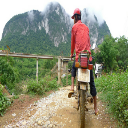

(1, 512)


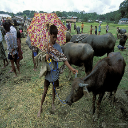

(1, 512)


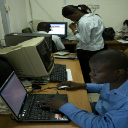

(1, 512)


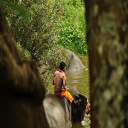

(1, 512)


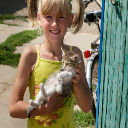

(1, 512)


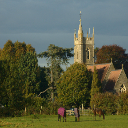

(1, 512)


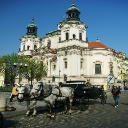

(1, 512)


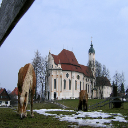

(1, 512)


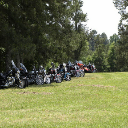

(1, 512)


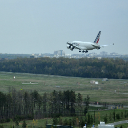

(1, 512)


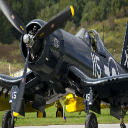

(1, 512)


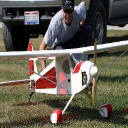

(1, 512)


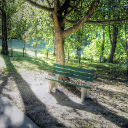

(1, 512)


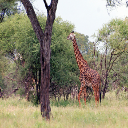

(1, 512)


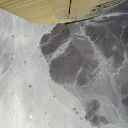

(1, 512)


In [ ]:
for img, clip_embeddings in ds_train.take(15):
  image_to_show = tf.keras.preprocessing.image.array_to_img(img)
  display(image_to_show)
  print(clip_embeddings.shape)

In [ ]:
import tensorflow as tf
import torch
import os
import matplotlib.pyplot as plt
os.chdir("/content/dl-fp/")
import clip_wrapper

class ClipCVAE(tf.keras.Model):
  def __init__(self, input_shape, latent_dim, dropout_rate):
    super(ClipCVAE, self).__init__()
    self.latent_dim = latent_dim
    self.shape_input = input_shape
    self.dropout_prob = dropout_rate

   #Dense layer used to shrink the embedding before inputing it in the decoder
    self.embedding_shrinker = tf.keras.layers.Dense(32)

    #First part of the encoder before concatenating the embedding
    self.encoder_part1= tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=self.shape_input, name="encoder_part1_inputlayer"),
            tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d1"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(256,5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d2"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d3"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d4"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten()])

    #In call, we will concatenate the output from the first part of the encoding with the CLIP embedding
    self.encoder_part2 = tf.keras.Sequential([
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation = "leaky_relu"),
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation="leaky_relu"),
            tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()

        ]
    )

    self.mu = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())
    self.logv = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())


    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(8 * 8 * 256, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((8,8,256)),
            tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(3, 5, strides=1, padding="same", activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal())
        ]
    )

  #Loss combining Binary Cross Entropy, KL Divergence and Structural Similarity
  def compute_loss(self, inputs, reconstructed, logv, mu):
    inputs, _ = inputs
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstructed)))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(inputs, reconstructed, max_val=1.0))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logv - tf.square(mu) - tf.exp(logv)))
    total_loss = reconstruction_loss + 0.5 * kl_loss + 0.1 * ssim_loss
    return total_loss / BATCH_SIZE

  def call(self, args, training=False):
    x, embedding = args
    embedding = tf.squeeze(embedding, axis=1)

    # First part of the encoding
    e1 = self.encoder_part1(x)
    e1_w_embedding = tf.concat([e1, embedding], axis=-1)

    # Go through part 2 of encoder
    e2 = self.encoder_part2(e1_w_embedding)

    # Mu and Logv
    mu = self.mu(e2)
    logv = self.logv(e2)

    # Sample Z (reparameterization trick)
    sigma = tf.math.sqrt(tf.math.exp(logv))
    eps = tf.random.normal([BATCH_SIZE, self.latent_dim])
    z = mu + tf.multiply(sigma, eps)

    if training:
      dropout_rate = self.dropout_prob
      z = tf.nn.dropout(z, rate=dropout_rate)

    embedding = self.embedding_shrinker(embedding)
    # Concatenate z with embedding again
    z_w_embedding = tf.concat([z, embedding], axis=-1)

    # Decode!
    res = self.decoder(z_w_embedding)

    return res, mu, logv

#Called when .fit is called
  def train_step(self, data):
      with tf.GradientTape() as tape:
          reconstruction, mu, logv = self(data, training=True)
          loss = self.compute_loss(data, reconstruction, logv, mu)
      grads = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
      return {'train loss': loss}

#Called at each epochs when .fit is called
  def test_step(self, data):
    reconstruction, mu, logv = self(data, training=False)
    loss = self.compute_loss(data, reconstruction, logv, mu)
    return {'valid loss': loss}

  def show_image(self, capt):
    z = tf.random.normal(shape=[1, self.latent_dim])
    encoding = clip_wrapper.get_text_encoding(capt)
    encoding = self.embedding_shrinker(encoding)
    z = tf.concat([z, encoding], axis=-1)
    img = self.decoder(z).numpy()[0]
    plt.imshow(img)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 103MiB/s]


In [ ]:
# Make directory for checkpoints and weights. This will simply error out if it already exists
!mkdir /content/dl-fp/ckpts
!mkdir /content/dl-fp/weights

mkdir: cannot create directory ‘/content/dl-fp/ckpts’: File exists
mkdir: cannot create directory ‘/content/dl-fp/weights’: File exists


In [ ]:
# Prepare for checkpoints
chk_pt = tf.keras.callbacks.ModelCheckpoint(
    "/content/dl-fp/ckpts/model_1_ckpt",
    monitor="val_valid",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

In [ ]:
cvae = ClipCVAE(input_shape=(128, 128, 3), latent_dim=128, dropout_rate=0.3)
cvae.compile(optimizer=tf.keras.optimizers.Adam(0.0005))
cvae.fit(ds_train_batched, epochs=10, batch_size=BATCH_SIZE, validation_data=ds_valid_batched, callbacks=[chk_pt])
cvae.save_weights("/content/dl-fp/weights/im_128_large.h5")

Epoch 1/10
475/475 [==============================] - 1043s 2s/step - train loss: 298861.2887 - val_valid loss: 11124.8984
Epoch 2/10
475/475 [==============================] - 1076s 2s/step - train loss: 10042.7657 - val_valid loss: 10369.5938
Epoch 3/10
475/475 [==============================] - 1084s 2s/step - train loss: 9972.6100 - val_valid loss: 9729.0947
Epoch 4/10
475/475 [==============================] - 1080s 2s/step - train loss: 9935.0622 - val_valid loss: 9681.2900
Epoch 5/10
475/475 [==============================] - 1037s 2s/step - train loss: 9906.1935 - val_valid loss: 9856.5371
Epoch 6/10
475/475 [==============================] - 1040s 2s/step - train loss: 9888.3262 - val_valid loss: 9957.0527
Epoch 7/10
475/475 [==============================] - 1036s 2s/step - train loss: 9875.6553 - val_valid loss: 10106.4492
Epoch 8/10
475/475 [==============================] - 1031s 2s/step - train loss: 9859.3085 - val_valid loss: 9654.7207
Epoch 9/10
475/475 [==============

In [ ]:
# Copy weights from Google Drive if they exist
!cp "/content/drive/MyDrive/Deep Learning FP/Weights/cvae_weights_128x128_imemb_large_og_dropout.h5" "/content/dl-fp/weights/cvae_weights.h5"

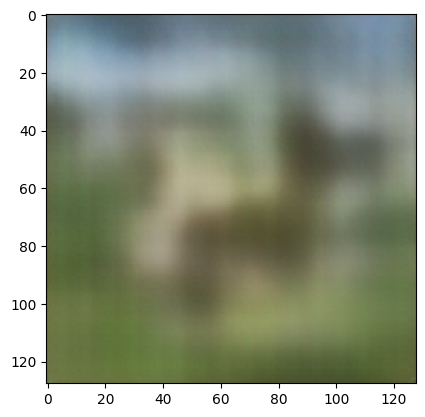

In [ ]:
# Prediction
cvae_predict = ClipCVAE(input_shape=(128, 128, 3), latent_dim=128, dropout_rate=0.3)
example_input = tf.random.normal((16, 128, 128, 3))
example_embedding = tf.random.normal((16, 1, 512))

# Dummy prediction to initialize model and be able to load weights
im = cvae_predict((example_input, example_embedding))[0]

cvae_predict.load_weights("/content/dl-fp/weights/cvae_weights.h5")
cvae_predict.show_image("cow in grass with blue sky")

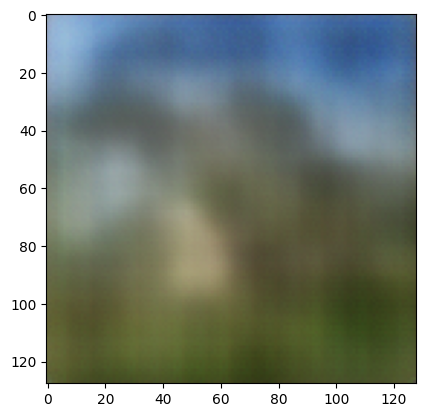

In [ ]:
#THIS CELL SHOULD BE RUN IF WHEIGHTS HAS ALREADY BEEN SAVES
#existing trained weight can be found in the "weights" folder

# Prediction
cvae_predict = ClipCVAE(input_shape=(128, 128, 3), latent_dim=128, dropout_rate=0.3)
example_input = tf.random.normal((16, 128, 128, 3))
example_embedding = tf.random.normal((16, 1, 512))

# Dummy prediction to initialize model and be able to load weights
im = cvae_predict((example_input, example_embedding))[0]

#loading the weights
cvae_predict.load_weights("/content/dl-fp/weights/cvae_weights.h5")
cvae_predict.show_image("grass and blue sky")

In [ ]:
# Save weights to Google Drive
!cp "/content/dl-fp/weights/im_128_large.h5" "/content/drive/MyDrive/Deep Learning FP/Weights/cvae_weights_128x128_imemb_large_og_dropout.h5"